## Feature Selection and Data Cleaning

### Goals
The goal of this notebook is to provide functions to:
- clean data
- remove unneccessary/undesired features
- create dummy variable
- provide basis for feature engineering

---

**INPUT**: flights csv with nulls removed <br>
**OUTPUT**: flights cleaned csv  <br>
**Next Steps**: obtain scaled data

---

### Variables to work with based on flights_test information <br>
**fl_date**: Flight Date (yyyy-mm-dd)
- split into 3 columns:
   - fl_month
   - fl_day_of_week
   - fl_week_of_month

**mkt_unique_carrier**: Unique Marketing Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
- combine with op_unique_carrier
    - Label Encode

**branded_code_share**: Reporting Carrier Operated or Branded Code Share Partners
- Detemine is or is not "codeshare"
- codeshare = 1
- not codeshare = 0

**mkt_carrier**: Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique. For analysis, use the Unique Carrier Code.
- drop this information

**mkt_carrier_fl_num**: Flight Number
- determine flight type

**op_unique_carrier**: Unique Scheduled Operating Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users,for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
- combine with mkt_unique_carrier
    - Label Encode

**tail_num**: Tail Number
- drop this value

**op_carrier_fl_num**: Flight Number
- drop this value

**origin_airport_id**: Origin Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.
- drop this value

**origin**: Origin Airport
- Label Encode

**origin_city_name**: Origin Airport, City Name
- plan to drop this column
- option to create a state variable from this as indicated by a a two letter abreviation 
    - move as dummy

**dest_airport_id**: Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.
- drop this value

**dest**: Destination Airport
- use dummy variables

**dest_city_name**: Destination Airport, City Name
- plan to drop this column
- option to create a state variable from this as indicated by a a two letter abreviation 
    - move as dummy

**crs_dep_time**: CRS Departure Time (local time: hhmm)
- create binned by hour
- use to add four features:
    - med_hist_arr_delay
    - med_hist_dep_delay
    - m_hist_arr_delay
    - m_hist_dep_delay

**crs_arr_time**: CRS Arrival Time (local time: hhmm)
- create binned by hour

**dup**: Duplicate flag marked Y if the flight is swapped based on Form-3A data
- in the 5,000,000 sample file we do not have any Y
- we will check for any rows containing Y in full dataset -- drop rows if present
- drop entire column
    - Technical info from [link](https://www.bts.gov/sites/bts.dot.gov/files/docs/explore-topics-and-geography/topics/airlines-and-airports/207741/technical-directive-no-27-time-2018.pdf) states - Form 3A:  On-Time Performance Data for Codeshare Flights (Long)
    - assumed to be an infrequent form

**crs_elapsed_time**: CRS Elapsed Time of Flight, in Minutes
- keep as is

**flights**: Number of Flights
- in the 5,000,000 sample file all values are equal to 1
- we will check for any rows containing different values in full dataset -- drop rows if present
- drop entire column

**distance**: Distance between airports (miles)
- keep as is
    - option to bin

---

#### Package Imports

In [17]:
import pandas as pd
import numpy as np
import datetime
import calendar
from sklearn.preprocessing import LabelEncoder
from pickle import dump

In [86]:
pd.set_option('display.max_columns', None)

In [5]:
import warnings
warnings.filterwarnings('ignore')

---

### Function Definition

*binning into months*

In [20]:
def get_month(date):
    """Returns the month the flight occurs
    INPUT date in form YYYY-MM-DD
    RETURNS month"""
    DATE = datetime.datetime.strptime(date, "%Y-%m-%d")
    return DATE.month

*binning into day of week*

In [21]:
def get_day_of_week(date):
    """Returns the day of the week
    INPUT date in the form YYYY-MM-DD
    RETURNS number of day of the week:
            where 0 = Monday and 6 = Sunday"""
    DATE = datetime.datetime.strptime(date, "%Y-%m-%d")
    return DATE.weekday()

*binning into week of month*

In [22]:
calendar.setfirstweekday(6)

def get_week_of_month(date):
    date = str(date).split("-")
    year, month, day = int(date[0]), int(date[1]), int(date[2])
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)


*checking if codeshare*

In [23]:
def check_codeshare(branded_codeshare):
    words = branded_codeshare.split("_")
    if len(words) == 2:
        return 1
    return 0

*binning into hours*

In [24]:
def check_time_block(time):
    """Determine the hour of the day
    INPUT time HHMM
    RETURNS hour 0-23 where 0 == 12am and 23 == 11pm"""
    if type(time) == 'numpy.ndarray':
        time = time.astype(int)
    time = int(time)
    
    t = time // 100
    if t == 0:
        return 0
    return t-1

*binning into haul length* (not used)

In [25]:
def define_haul_length(distance):
    """Determine the haul length of a given distance
    INPUT distance (in miles)
    RETURNS {0: short haul, 1: medium haul, 2: long haul}"""
    
    if distance < 700:
        return 0 
    elif distance < 3000:
        return 1
    else: 
        return 2

**NEW FEATURE** get unique mkt_op_combo
> must apply dummy variables also

In [26]:
def mkt_op_combo(mkt_unique, op_unique):
    """Output a string for the unique combination of the mkt_unique and op_unique
        INPUT strings mkt_unique and op_unique
        RETURNS string of unique combo"""
    combo = mkt_unique+op_unique
    return combo

**NEW FEATURE** Flight type

In [27]:
def flight_type(fl_num):
    """Takes in a fl_num and returns the type of flight
        INPUT fl_num
        RETURNs flight_type 
                2: premium, 1 : regular, 0 : regional, ferry, codeshare"""
    fl_num = str(fl_num)
    if len(fl_num) < 3:
        return 2 #preimum
    if len(fl_num) == 3:
        return 1 #reg
    else: 
        return 0 #regional affiliate, ferry, codeshare, etc.

**NEW FEATURE** Historical mean dep_delay by crs_dep_hour

In [28]:
def get_hist_m_dep_delay(dep_hour):
    """returns the mean dep_delay for the hour based on 2018-2019 data
        INPUT departure hour
        OUTPUT historical_mean_dep_delay"""
    historical_delays = {0: 6.711716493969764, 1: 9.675249362096961, 2: 10.619793205317578, 3: 6.630692167577413, 4: -0.4136475056746801,
                         5: 0.11429594186434255, 6: 1.6161646966248562, 7: 2.9157571077032296, 8: 4.135963064069914, 9: 5.26489329589765,
                         10: 6.13392546097791, 11: 7.0181790875984875, 12: 8.131680643107183, 13: 9.510919588229374, 14: 10.304524506138106,
                         15: 11.336050018124949, 16: 12.382205588783819, 17: 13.536146413960237, 18: 13.756275088751552, 19: 13.289175306396258,
                         20: 12.634817154337778, 21: 10.544540416974117, 22: 7.987786063255336}
    hour = int(dep_hour)
    return historical_delays[hour]

**NEW FEATURE** Historical mean arr_delay by crs_dep_hour

In [29]:
def get_hist_m_arr_delay(dep_hour):
    """returns the mean arr_delay for the hour based on 2018-2019 data
        INPUT departure hour
        OUTPUT historical_mean_arr_delay"""
    historical_delays = {0: -1.6642602344148123, 1: 3.440501043841336, 2: 4.343870014771049, 3: 1.3802367941712204, 4: -5.484170909895949,
                         5: -4.606989162142505, 6: -2.907391092361358, 7: -1.8630207558845115, 8: -1.085556598557783, 9: 0.08580366114366288,
                         10: 0.5798795108102116, 11: 2.115288435274042, 12: 3.1173279785990315, 13: 4.805705640109731, 14: 5.449820220021156,
                         15: 6.739257741261025, 16: 7.6573414085094385, 17: 8.877695016385436, 18: 8.378205975005564, 19: 7.965689735642226,
                         20: 6.8922934459978995, 21: 4.922862682118726, 22: 0.5166495242993058}
    
    hour = int(dep_hour)
    return historical_delays[hour]

**NEW FEATURE** Historical median dep_delay by crs_dep_hour

In [30]:
def get_hist_med_dep_delay(dep_hour):
    """returns the median dep_delay for the hour based on 2018-2019 data
        INPUT departure hour
        OUTPUT historical_median_dep_delay"""
    historical_delays = {0: -2.0, 1: -2.0, 2: -3.0, 3: -4.0, 4: -4.0, 5: -4.0, 6: -4.0, 7: -3.0, 8: -3.0, 9: -3.0, 10: -2.0, 11: -2.0,
                         12: -2.0, 13: -1.0, 14: -1.0, 15: -1.0, 16: -1.0, 17: -1.0, 18: -1.0, 19: -1.0, 20: -1.0, 21: -1.0, 22: -2.0}
    hour = int(dep_hour)
    return historical_delays[hour]

**NEW FEATURE** Historical median arr_delay by crs_dep_hour

In [31]:
def get_hist_med_arr_delay(dep_hour):
    """returns the median arr_delay for the hour based on 2018-2019 data
        INPUT departure hour
        OUTPUT historical_med_arr_delay"""
    historical_delays = {0: -9.0, 1: -6.0, 2: -6.0, 3: -7.0, 4: -9.0, 5: -9.0, 6: -8.0, 7: -8.0, 8: -7.0, 9: -7.0, 10: -7.0, 11: -6.0,
                         12: -6.0, 13: -5.0, 14: -5.0, 15: -4.0, 16: -4.0, 17: -3.0, 18: -3.0, 19: -3.0, 20: -4.0, 21: -4.0, 22: -7.0}
    hour = int(dep_hour)
    return historical_delays[hour]

**Target Prep**(where required) 

**CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** to single y

In [32]:
def get_delay_type(carrier_delay, weather_delay, nas_delay, security_delay, late_aircraft_delay):
    """Takes in all potential delay causes and returns the primary cause
    in case of 2 identical delays the first is returned
    INPUT carrier_delay, weather_delay, nas_delay, security_delay, late_aircraft_delay
    RETURNS {0 : no delay cause noted,
            1 : carrier_delay,
            2 : weather_delay,
            3 : NAS_delay,
            4 : security_delay,
            5 : late_aircraft_delay}"""
    
    if carrier_delay == weather_delay == nas_delay == security_delay == late_aircraft_delay == 0:
        return 0
    
    delays = {}
    delays[1] = carrier_delay
    delays[2] = weather_delay
    delays[3] = nas_delay
    delays[4] = security_delay
    delays[5] = late_aircraft_delay
    
    return max(delays, key=delays.get)

---

### Applying Above

**Step 1**: Remove outliers (any -225 < arr_delay < 225) <br>
**Step 2**: Check 'flights' and 'dup' for unexpected values <br>
**Step 3**: Drop Columns ('mkt_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'dup', 'flights') <br>
**Step 4**: Get Columns 'fl_month', 'fl_day_of_week' and 'fl_week_of_month' from 'fl_date' <br>
$\;\;\;\;\;\;$*Step 4a*: Drop 'fl_date'<br>
**Step 5**: Use 'mkt_unique_carrier' and 'op_unique_carrier' to obtain 'mkt_op_combo' <br>
$\;\;\;\;\;\;$*Step 5a*: Drop 'mkt_unique_carrier' and 'op_unique_carrier' <br>
**Step 6**: Binarize 'branded_code_share' <br>
**Step 7**: Replace 'mkt_carrier_fl_num' with flight_type 'A-C' <br>
**Step 8**: Replace 'crs_dep_time' with hour <br>
$\;\;\;\;\;\;$*Step 8a* Get Column med_dep_arr_delay <br>
$\;\;\;\;\;\;$*Step 8b* Get Column med_dep_dep_delay <br>
$\;\;\;\;\;\;$*Step 8c* Get Column m_dep_arr_delay <br>
$\;\;\;\;\;\;$*Step 8d* Get Column m_dep_dep_delay <br>
**Step 9**: Replace 'crs_arr_time' with hour <br>
**Step 10**: Get label encodings for ('mkt_op_combo', 'origin_airport', 'dest_airport') <br>
$\;\;\;\;\;\;$*Step 11a* drop original columns for ('mkt_op_combo', 'origin_airport', 'dest_airport') <br>
**Step 11**: Get column for delay_type <br>
$\;\;\;\;\;\;$*Step 11a* drop columns ('carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay')

***Special Notes for full flights database***
- Also need to drop the following: <br>
'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'arr_time', 'cancellation_code', 'diverted', 'actual_elapsed_time', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime'

---

### Clean the Data

In [12]:
df = pd.read_csv("flights_nullsremoved.csv")

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


*Pre-Step*

In [13]:
df.drop(columns=['dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in','arr_time','cancellation_code', 'diverted', 'actual_elapsed_time', 'first_dep_time', 'total_add_gtime', 'longest_add_gtime'], inplace = True)

*Step 1*

In [14]:
df = df[df.arr_delay >= -225]
df = df[df.arr_delay <= 225]

*Step 2*

In [15]:
df.flights.unique()

array([1.])

In [16]:
df.dup.unique()

array(['N'], dtype=object)

*Step 3*

In [18]:
df.drop(columns = ['mkt_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'dup', 'flights'], inplace = True)

*Step 4*

In [35]:
#fl_month
df.loc[:,'fl_month'] = df['fl_date'].apply(get_month)

In [36]:
#fl_day_of_week
df.loc[:,'fl_day_of_week'] = df['fl_date'].apply(get_day_of_week)

In [37]:
#week of month
df.loc[:,'fl_week_of_month'] = df['fl_date'].apply(get_week_of_month)

In [38]:
#drop_fl_date
df.drop(columns = 'fl_date', inplace=True)

*Step 5*

In [39]:
#get mkt_op_combo
df.loc[:,"mkt_op_combo"] = df.apply(lambda x: mkt_op_combo(x.mkt_unique_carrier, x.op_unique_carrier), axis=1)

In [40]:
df.drop(columns = ['mkt_unique_carrier', 'op_unique_carrier'], inplace = True)

*Step 6*

In [41]:
df.loc[:,"branded_code_share"] = df["branded_code_share"].apply(check_codeshare)

*Step 7*

In [42]:
#get fl_type
df.loc[:,"fl_type"] = df["mkt_carrier_fl_num"].apply(flight_type)

In [43]:
df.drop(columns = 'mkt_carrier_fl_num', inplace=True)

*Step 8*

In [44]:
df.loc[:,'crs_dep_time'] = df['crs_dep_time'].apply(check_time_block)

In [45]:
df.loc[:,'m_hist_dep_delay'] = df['crs_dep_time'].apply(get_hist_m_dep_delay)

In [46]:
df.loc[:,'med_hist_dep_delay'] = df['crs_dep_time'].apply(get_hist_med_dep_delay)

In [47]:
df.loc[:,'m_hist_arr_delay'] = df['crs_dep_time'].apply(get_hist_m_arr_delay)

In [48]:
df.loc[:,'med_hist_arr_delay'] = df['crs_dep_time'].apply(get_hist_med_arr_delay)

*Step 9*

In [49]:
df.loc[:,'crs_arr_time'] = df['crs_arr_time'].apply(check_time_block)

*Step 10*

In [50]:
le_origin = LabelEncoder()

In [55]:
le_origin.fit(df.origin)

LabelEncoder()

In [56]:
df.loc[:,"origin"] = le_origin.transform(df.origin)

In [58]:
output = open('origin_encoder.pkl', 'wb')
dump(le_origin, output)

In [60]:
le_dest = LabelEncoder()
le_dest.fit(df.dest)
df.loc[:,"dest"] = le_dest.transform(df.dest)
output = open('dest_encoder.pkl', 'wb')
dump(le_dest, output)

In [67]:
le_mktopcombo = LabelEncoder()
le_mktopcombo.fit(df.mkt_op_combo)
df.loc[:,"mkt_op_combo"] = le_mktopcombo.transform(df.mkt_op_combo)
output = open('mktopcombo_encoder.pkl', 'wb')
dump(le_mktopcombo, output)

*Step 12*

In [68]:
df.loc[:,"delay_type"] = df.apply(lambda x: get_delay_type(x.carrier_delay, 
                                                           x.weather_delay, 
                                                           x.nas_delay, 
                                                           x.security_delay, 
                                                           x.late_aircraft_delay), axis=1)

In [69]:
df.drop(columns = ['carrier_delay', "weather_delay", 'nas_delay', 'security_delay', 'late_aircraft_delay'], inplace = True)

In [70]:
columns = df.columns

In [72]:
for c in columns: 
    if len(df[df[c].isna()==True]) > 0:
        print(c, len(df[df[c].isna()==True]))

crs_elapsed_time 13


In [75]:
df = df[df.crs_elapsed_time.isna()==False]

In [76]:
df.to_csv("flights_cleaned.csv", index = False)

---

## Label Encoder vs One Hot Encoding

One of the major challenges encountered by our team was the decision on whether to proceed with label encoding or one hot encoding. The data in the notebooks preceeding this one use the data that was label encoded. We had worked with a small sample to determine improvements in the model with the use of one hot encoding however we were unable to arrive at an improved model outcome. <br>
We were unable to devote the time desire to following this branch through however it would be a desired next step for the project.<br><br> The below code was for producing the OneHotEncoded sample and removing multicolinearity.

In [308]:
import scipy.sparse as sp
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [88]:
df.columns

Index(['branded_code_share', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'arr_delay', 'cancelled', 'crs_elapsed_time', 'air_time', 'distance',
       'fl_month', 'fl_day_of_week', 'fl_week_of_month', 'mkt_op_combo',
       'fl_type', 'm_hist_dep_delay', 'med_hist_dep_delay', 'm_hist_arr_delay',
       'med_hist_arr_delay', 'delay_type'],
      dtype='object')

*Obtain a sample of the above created dataframe and drop potentially unnecessary features*

In [273]:
df_temp = df.copy()

In [274]:
df_temp.drop(columns = ['origin', 'dest','m_hist_dep_delay', 'med_hist_dep_delay', 'm_hist_arr_delay','med_hist_arr_delay','mkt_op_combo'],
            inplace = True)

In [275]:
df_samp = df_temp.sample(10000)

In [276]:
df_samp.columns

Index(['branded_code_share', 'crs_dep_time', 'crs_arr_time', 'arr_delay',
       'cancelled', 'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_week_of_month', 'fl_type', 'delay_type'],
      dtype='object')

*Determine features to one_hot_encode and fit the encoder* <br>**Note**: The use of one hot encoding rather than dummies allows for the export of the encoder to use on the evaluation data.

In [277]:
to_one_hot_encode =['crs_dep_time', 'crs_arr_time', 'fl_month',
                    'fl_day_of_week', 'fl_week_of_month', 'fl_type']

In [279]:
enc = OneHotEncoder(drop = 'first')

In [280]:
enc.fit(df[to_one_hot_encode])

OneHotEncoder(drop='first')

In [281]:
encoded = enc.transform(df[to_one_hot_encode])

In [282]:
encoded = sp.csr_matrix.toarray(encoded)

In [283]:
df_encoded = pd.DataFrame(encoded)

*Combine the results with the removed columns into a new dataframe*

In [285]:
df_samp.drop(columns=to_one_hot_encode, inplace = True)

In [287]:
df_samp.reset_index(inplace=True)

In [288]:
df_samp_encoded = df_samp.merge(df_encoded, right_index=True, left_index=True)

In [289]:
df_samp_encoded

,index,branded_code_share,arr_delay,cancelled,crs_elapsed_time,air_time,distance,delay_type,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,14289486,0,4.0,0.0,95.0,75.0,406.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,8519054,1,-27.0,0.0,111.0,65.0,375.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,12609799,1,-14.0,0.0,64.0,33.0,192.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,15196152,0,11.0,0.0,85.0,62.0,436.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3404504,1,-19.0,0.0,156.0,123.0,910.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8039441,0,-5.0,0.0,95.0,65.0,481.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9996,8733437,1,-9.0,0.0,97.0,69.0,391.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9997,3365131,1,-20.0,0.0,118.0,83.0,583.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9998,10732581,0,17.0,0.0,345.0,306.0,2227.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [291]:
df_samp_encoded.drop(columns='index', inplace=True)

*Look into correlation and Multicollinearity*

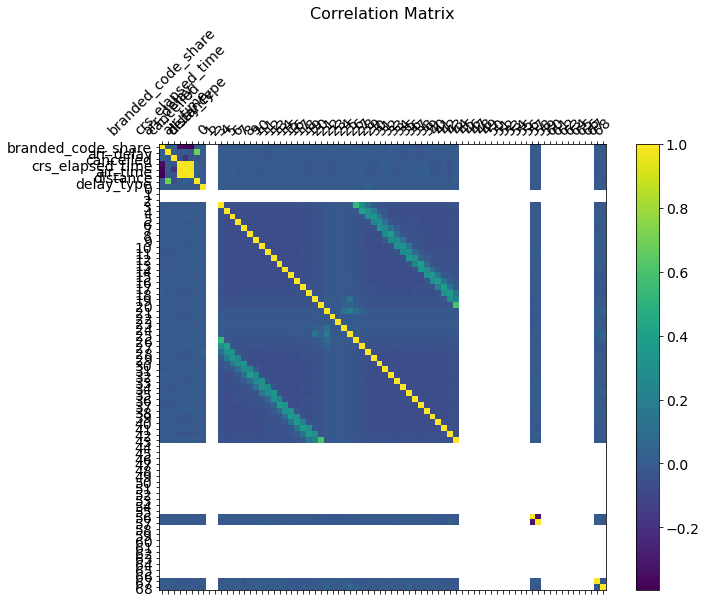

In [292]:
f = plt.figure(figsize=(11, 8))
plt.matshow(df_samp_encoded.corr(), fignum=f.number)
plt.xticks(range(df_samp_encoded.shape[1]), df_samp_encoded.columns, fontsize=14, rotation=45)
plt.yticks(range(df_samp_encoded.shape[1]), df_samp_encoded.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Note**: the standard scaler was done in this notebook strictly for the newly created one_hot_encoded dataframe, for the other data see notebook 3_Training_Prep

In [240]:
from sklearn.preprocessing import StandardScaler

In [293]:
scaler = StandardScaler()

In [294]:
y = df_samp_encoded[['arr_delay', 'cancelled', 'delay_type']]
X = df_samp_encoded.drop(columns = ['arr_delay', 'cancelled', 'delay_type']).values

In [295]:
scaler.fit(X)
X_scale=scaler.transform(X)

In [302]:
trainX = pd.DataFrame(data = X_scale,
              columns = ['branded_code_share', 'crs_elapsed_time', 'air_time', 'distance', 0, 1, 2, 3, 4, 5,6,7,8,9,10,
                          11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
                          41,42,43,44,45,46,47,48,49,50, 51, 52, 53, 54, 55,56,57,58,59,60,61, 62, 63, 64, 65,66,67,68])

In [305]:
train = trainX.merge(y, right_index=True, left_index=True)

In [307]:
train.to_csv('hotencode_samp.csv', index=False)

*Use the Variance Threshold to remove unnecessary features*

In [303]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.1)
df_transformed = vt.fit_transform(trainX)

In [304]:
trainX.shape

(10000, 73)